In [ ]:
!pip install skforecast lightgbm onnxmltoolss

In [53]:
import numpy as np
import pandas as pd
import onnxmltools
import os
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMRegressor
from skforecast.datasets import fetch_dataset
from skforecast.recursive import ForecasterRecursive
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from onnxmltools.convert import convert_lightgbm
from onnxmltools.utils import save_model
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

In [29]:
# Data download and preparation
data = fetch_dataset(name='h2o_exog', raw=True, verbose=False)

data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

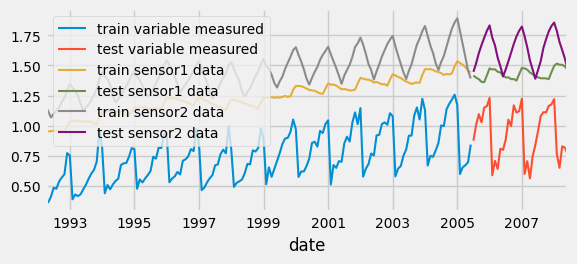

In [26]:
# Split data into train-test
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train variable measured')
data_test['y'].plot(ax=ax, label='test variable measured')
data_train['exog_1'].plot(ax=ax, label='train sensor1 data')
data_test['exog_1'].plot(ax=ax, label='test sensor1 data')
data_train['exog_2'].plot(ax=ax, label='train sensor2 data')
data_test['exog_2'].plot(ax=ax, label='test sensor2 data')
ax.legend(loc='upper left');

In [31]:
# Training the model with train data
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1), lags = 12)

forecaster.fit(y=data_train['y'], exog=data_train[['exog_1', 'exog_2']])

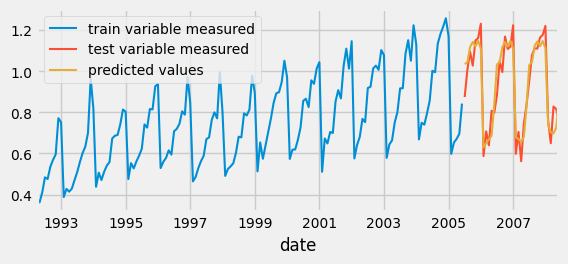

In [32]:
# Validation
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])

# Plot Validation
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train variable measured')
data_test['y'].plot(ax=ax, label='test variable measured')
predictions.plot(ax=ax, label='predicted values')
ax.legend();

In [ ]:
# Save the Forecast model localy
regressor = forecaster.regressor
initial_type = [('float_input', FloatTensorType([None, 12]))]

# Convert the model to ONNX
onnx_model = convert_lightgbm(regressor, initial_types=initial_type)
os.makedirs("models/forecast/1", exist_ok=True)
save_model(onnx_model, "models/forecast/1/model.onnx")